In [1]:
%reload_ext autoreload
%autoreload 2

# %matplotlib qt

import time
from tqdm import tqdm
import numpy as np
import scipy as sp
import sklearn
import torch
import torch.nn.functional as F
from torch import nn
from torchvision.transforms import v2 as transforms

from matplotlib import pyplot as plt

from networkAlignmentAnalysis.models.registry import get_model
from networkAlignmentAnalysis.datasets import get_dataset
from networkAlignmentAnalysis.experiments.registry import get_experiment
from networkAlignmentAnalysis import utils
from networkAlignmentAnalysis import files
from networkAlignmentAnalysis import train

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using device: ', DEVICE)

using device:  cpu


In [5]:
def get_data(modes, signal_dist, noise_amplitude, batch_size):
    signal = signal_dist.sample((batch_size,))
    data = signal @ modes + torch.normal(0, noise_amplitude, (batch_size, modes.size(1)))
    return signal, data

def train(teacher, student, modes, signal_dist, noise_amplitude, batch_size=256, num_epochs=1000):
    optimizer = torch.optim.SGD(student.parameters(), lr=1e-2)
    lossfn = torch.nn.MSELoss()
    track_loss = []
    alignment = []
    for epoch in tqdm(range(num_epochs)):
        signal, data = get_data(modes, signal_dist, noise_amplitude, batch_size)
        signal, data = signal.to(DEVICE), data.to(DEVICE)

        optimizer.zero_grad()
        target = teacher(signal)
        output = student(data, store_hidden=True)
        loss = lossfn(output, target)
        loss.backward()
        optimizer.step()
        track_loss.append(loss.item())
        alignment.append(student.measure_alignment(data, precomputed=True))

    alignment = [torch.stack(a) for a in utils.transpose_list(alignment)] # list across layers, (epochs x dim) 
    return student, track_loss, alignment

In [8]:
N = 100
num_modes = 50
shape = 0.7*torch.ones((num_modes,))
modes = torch.normal(0, 1, (num_modes, N))
amplitude = torch.rand((num_modes,))*0.9 + 0.1
signal_dist = torch.distributions.gamma.Gamma(shape, amplitude)
noise_amplitude = 0.2

model_name = "MLP"
teacher = get_model(model_name, build=True, input_dim=num_modes, dropout=0.0, ignore_flag=False, linear=True).to(DEVICE).eval()
student = get_model(model_name, build=True, input_dim=N, dropout=0.0, ignore_flag=False).to(DEVICE)

student, track_loss, alignment = train(teacher, student, modes, signal_dist, noise_amplitude)
mean_alignment = torch.stack([torch.mean(align, dim=1) for align in alignment])

100%|██████████| 1000/1000 [00:03<00:00, 255.67it/s]


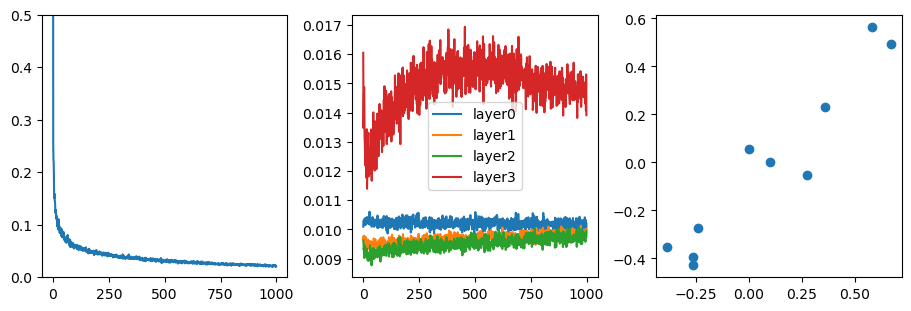

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), layout='constrained')
ax[0].plot(track_loss)
ax[0].set_ylim(0, 0.5)
for layer in range(len(alignment)):
    ax[1].plot(mean_alignment[layer], label=f"layer{layer}")
ax[1].legend()

signal, data = get_data(modes, signal_dist, noise_amplitude, 1)
ax[2].scatter(teacher(signal).detach(), student(data).detach())
plt.show()


(2,) (2, 2)


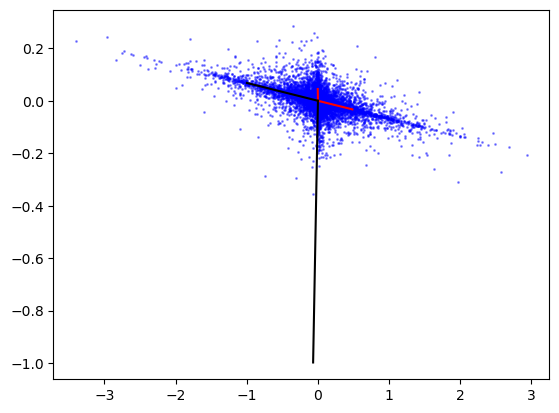

In [45]:
N, S = 2, 10000
num_modes = 2
nonnormality = 1.5
a = b = 1/nonnormality
modes = np.random.normal(0, 1, (num_modes, N)) * np.random.normal(0, 1, num_modes).reshape(-1, 1)
signal = np.random.gamma(0.5, 1, (S, num_modes)) * np.sign(np.random.random((S, num_modes))-0.5)
data = signal @ modes
w, v = [np.array(o) for o in utils.smart_pca(torch.tensor(data).T)]
print(w.shape, v.shape)

plt.scatter(data[:, 0], data[:, 1], s=1, c=('b', 0.4))
for mode in modes:
    plt.plot([0, mode[0]], [0, mode[1]], c='r')
for evec in v.T:
    plt.plot([0, evec[0]], [0, evec[1]], c='k')

plt.show()

In [12]:
@torch.no_grad()
def cvPCA(X1, X2):
    """X1, X2 are both (dimensions x samples)"""
    D, B = X1.shape
    assert X2.shape == (D, B), "shape of X1 and X2 is not the same"
    _, u = utils.smart_pca(X1)
    
    cproj0 = X1.T @ u
    cproj1 = X2.T @ u
    ss = (cproj0 * cproj1).mean(axis=0)
    return ss

def get_num_components(nc, shape):
    return nc if nc is not None else min(shape)

@torch.no_grad()
def shuff_cvPCA(X1, X2, nshuff=5, cvmethod=cvPCA):
    """X1, X2 are both (dimensions x samples)"""
    D, B = X1.shape
    assert X2.shape == (D, B), "shape of X1 and X2 is not the same"
    nc = get_num_components(None, (D, B))
    ss=torch.zeros((nshuff,nc))
    X = torch.stack((X1, X2))
    for k in range(nshuff):
        iflip = 1*(torch.rand(B) > 0.5)
        X1c = torch.gather(X, 0, iflip.view(1, 1, -1).expand(1, D, -1)).squeeze(0)
        X2c = torch.gather(X, 0, -(iflip-1).view(1, 1, -1).expand(1, D, -1)).squeeze(0)
        ss[k]=cvmethod(X1c, X2c)
    return ss

In [13]:
dataset = get_dataset("MNIST", build=True)
images = []
labels = []
for batch in tqdm(dataset.train_loader):
    cimages, clabels = dataset.unwrap_batch(batch)
    images.append(cimages)
    labels.append(clabels)
images = torch.concatenate(images, dim=0)
images = images.view(images.size(0), -1)
images = images - images.mean(dim=0)
labels = torch.concatenate(labels, dim=0)
print(images.shape, labels.shape)

# get stacked indices to the elements of each class
classes = torch.unique(labels)
num_classes = len(classes)
idx_to_class = [torch.where(labels == ii)[0] for ii in classes]
num_per_class = [len(idx) for idx in idx_to_class]
min_per_class = min(num_per_class)
if any([npc > min_per_class for npc in num_per_class]):
    idx_to_class = [idx[:min_per_class] for idx in idx_to_class]

# use single tensor for fast indexing
idx_to_class = torch.stack(idx_to_class).unsqueeze(2)

# (classes, images, image_dimension)
images_by_class = torch.gather(images.unsqueeze(0).expand(num_classes, -1, -1), 1, idx_to_class.expand(-1, -1, images.size(1)))

100%|██████████| 59/59 [00:09<00:00,  6.05it/s]


torch.Size([60000, 784]) torch.Size([60000])


In [16]:
# make a CV dataset
num_per_class = images_by_class.size(1)
random_sort = torch.randperm(num_per_class)
train_examples = random_sort[:num_per_class//2]
test_examples = random_sort[num_per_class//2:num_per_class//2+num_per_class//2]
images_train = images_by_class[:, train_examples].reshape(-1, images.size(1))
images_test = images_by_class[:, test_examples].reshape(-1, images.size(1))

# measure eigenfeatures
w, v = utils.smart_pca(images.T)
w = w / torch.sum(w)

# cvPCA from method
cc = shuff_cvPCA(images_train.T, images_test.T, nshuff=5)
cc = cc.mean(dim=0)
cc = cc / torch.sum(cc)

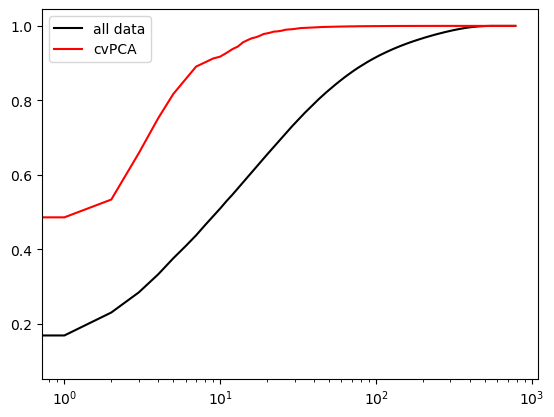

In [21]:
plt.plot(range(784), torch.cumsum(w, 0), c='k', label='all data')
plt.plot(range(784), torch.cumsum(cc, 0), c='r', label='cvPCA')
plt.xscale('log')
# plt.yscale('log')
# plt.ylim(1e-5)
plt.legend()
plt.show()


# I'd like to compare these cvPCA results to the observed alignment distribution
# to determine if the reason alignment and delta alignment is much higher than expected
# according to Ila Fiete is because of the batching implicitly "cross-validating" the 
# updates according to class-dependent structure rather than simply all structure. 

# In other words, if it is the case that the network primarily learns stimulus specific
# dimensions, rather than full data dimensions, it may be because any other dimensions
# are ignored by the batching. (And therefore implicitly prevents over-generalization!)

# Other experiment: Determine if these dimensions are overrepresented in the dataset. 